# Weather Image Classification Part Two

# Imports

In [94]:
import os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import ImageFile, Image


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

# Constants

In [95]:
INPUT_SHAPE = (224,224, 3)
PATH = "/Users/maukanmir/Downloads/dataset/"
BATCH_SIZE = 32

# Functions

In [96]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_process_images(img_path, target_size=INPUT_SHAPE):
  
  try:
    with Image.open(img_path) as image:
      image = image.resize(target_size[:2])
      image = image.convert("RGB")
      
      img_array = np.array(image)/255.0
      img_array = img_array.astype(np.float32)
      
      return img_array
  except IOError as e:
    print(f"Error loading image: {e}")
    return None

def grab_images(PATH):
  images, labels = [], []
  for root, dir, files in os.walk(PATH):
    for file in files:
      if file.lower().endswith((".png", ".jpeg", ".jpg")):
        file_path = os.path.join(root, file)
        img = load_process_images(file_path)
        if img is not None:
          images.append(img)
          label = root.split(os.sep)[-1]
          labels.append(label)
  
  images, labels = np.array(images), np.array(labels)
  
  return images, labels

def create_model(n_classes, input):
  
  model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(input)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(n_classes, activation="softmax")
  ])
  
  model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
  )
  model.summary()
  
  return model

def plot_images_with_labels(images, labels, label_encoder, num_images=12, img_size=INPUT_SHAPE):
  plt.figure(figsize=(10,10))
  for i in range(num_images):
    plt.subplot(3,4,i+1)
    img = images[i].reshape(img_size[0], img_size[1], 3)
    plt.imshow(img)
    plt.title(label_encoder.inverse_transform([labels[i]])[0])
    plt.axis("off")
  plt.show()

# Grab Images

In [97]:
X ,y = grab_images(PATH)

In [98]:
label_encoder = LabelEncoder()

y_int = label_encoder.fit_transform(y)

In [99]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_int, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [100]:
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 4116
Validation set size: 1373
Test set size: 1373


# Let's take a look at some of our images

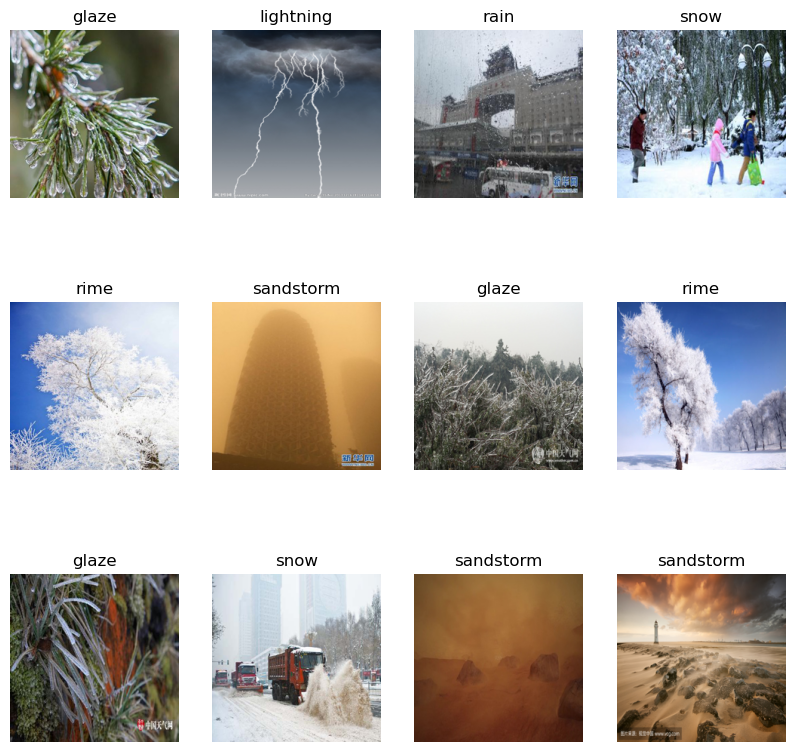

In [101]:
plot_images_with_labels(X_train, y_train, label_encoder)

# Data Augmentation

In [102]:
train_datagen = ImageDataGenerator(
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode="nearest"
)

validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
  X_train, y_train,
  batch_size=BATCH_SIZE
)

val_generator = validation_datagen.flow(
  X_val, y_val,
  batch_size=BATCH_SIZE
)

test_generator = test_datagen.flow(
  X_test, y_test,
  batch_size=BATCH_SIZE
)


# Create Model

In [103]:
model = create_model(len(label_encoder.classes_),INPUT_SHAPE)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 128)     

# Early Stopping

In [104]:
early_stopping = EarlyStopping(
  monitor="val_loss",
  min_delta=0.01,
  patience=5,
  verbose=0,
  mode="min",
  restore_best_weights=True
)

# Call Model

In [ ]:
history = model.fit(
  train_generator,
  steps_per_epoch = X_train.shape[0]// BATCH_SIZE,
  epochs=15,
  validation_data=val_generator,
  validation_steps= X_val.shape[0]//BATCH_SIZE,
  callbacks=[early_stopping]
)

test_loss, test_acc = model.evaluate(test_generator, steps=X_test.shape[0]/BATCH_SIZE)
print(f"Test Accuracy", test)